In [1]:
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
from typing import List, Tuple
from tqdm import tqdm
import itertools

In [3]:
import jax.numpy as jnp
from jax import value_and_grad, jit, vmap, random
from jax import Array
from jax.config import config
config.update("jax_debug_nans", True)
config.update("jax_array", True)

In [4]:
def init_layer(key, in_dims: List[int], out_dim: int) -> List[Array]:
    """
    Initialize weight and bias terms for a layer that takes in inputs with
    dimensions in_dims and then outputs values with dimension out_dim.

    in_dims: dimensions of the input, i.e. in_dim[0] x 1, in_dim[1] x 1, ...
    out_dim: dimension of the output, i.e. out_dim x 1

    Return the weight matrices and bias vector for the layer.

    weight: out_dim x in_dim[0], out_dim x in_dim[1], ...
    bias: out_dim x 1
    """
    b_key, *w_keys = random.split(key, num=len(in_dims) + 1)
    weights = []
    for w_key, in_dim in zip(w_keys, in_dims):
        bound = jnp.sqrt(1 / in_dim)
        weight = random.uniform(w_key, (out_dim, in_dim), minval=-bound, maxval=bound)
        weights.append(weight)
    bias = random.uniform(b_key, (out_dim,), minval=-bound, maxval=bound)
    return weights + [bias]


def init_unet(key, sizes: List[int]) -> List[List[Array]]:
    """
    Initialize a U-Net style linear model with layer input and output
    dimensions from sizes. When sizes is of length N, the resulting model
    will contain 2 * (N-1) + 1 layers.

    key: random.PRNGKey(seed), used for randomness in initialization.
    sizes: list of integers to be used for layer dimension sizes.

    Return a list of layer parameters, where each layer is described as a
    list of the form: (weight, bias) for layers 1 through N and
    (prev_weight, res_weight, bias) for layers (N+1) through (2N-1).
    """
    n = len(sizes)
    key, *layer_keys = random.split(key, num=2 * n)

    model = []
    for i in jnp.arange(n - 1):
        # (weight, bias)
        layer = init_layer(layer_keys[i], [sizes[i]], sizes[i + 1])
        model.append(layer)

    # (weight, bias)
    layer = init_layer(layer_keys[n - 1], [sizes[n - 1]], sizes[n - 1])
    model.append(layer)

    for i in jnp.flip(jnp.arange(1, n)):
        # (prev_weight, res_weight, bias)
        layer = init_layer(
            layer_keys[n + i - 1], [sizes[i], sizes[i - 1]], sizes[i - 1]
        )
        model.append(layer)

    return model


In [5]:
model_key = random.PRNGKey(0)
# BEGIN SOLUTION
model = init_unet(model_key, [9, 6, 4])
# END SOLUTION
for i, layer in enumerate(model):
    print(f"Layer {i}:")
    for j, weight in enumerate(layer[:-1]):
        print(f"\tW{j}: {weight.shape}")
    bias = layer[-1]
    print(f"\tb : {bias.shape}")

Layer 0:
	W0: (6, 9)
	b : (6,)
Layer 1:
	W0: (4, 6)
	b : (4,)
Layer 2:
	W0: (4, 4)
	b : (4,)
Layer 3:
	W0: (6, 4)
	W1: (6, 6)
	b : (6,)
Layer 4:
	W0: (9, 6)
	W1: (9, 9)
	b : (9,)


In [6]:
@jit
def sigmoid(x: Array) -> Array:
    """
    Compute the element-wise sigmoid of x.
    """
    return 0.5 * (jnp.tanh(x / 2) + 1)


@jit
def relu(x: Array) -> Array:
    """
    Compute the element-wise RELU of x.
    """
    return jnp.maximum(0, x)

In [7]:
@jit
def predict(model: List[List[Array]], x: Array, t: int) -> Array:
    """
    Return the prediction of the U-Net model for given inputs x and t.

    x: state at time t
    t: number of timesteps
    """
    n = len(model)
    mid = n // 2
    xt = jnp.append(x, t)

    res_xt = []
    for i in range(0, mid):
        res_xt.append(xt)
        weight, bias = model[i]
        xt = relu(jnp.dot(weight, xt) + bias)
        # xt = sigmoid(jnp.dot(weight, xt) + bias)

    weight, bias = model[mid]
    xt = relu(jnp.dot(weight, xt) + bias)
    # xt = sigmoid(jnp.dot(weight, xt) + bias)

    for i in range(mid + 1, n):
        prev_weight, res_weight, bias = model[i]
        xt = jnp.dot(prev_weight, xt) + jnp.dot(res_weight, res_xt.pop()) + bias
        if i < n - 1:
            xt = relu(xt)
            # xt = sigmoid(xt)

    return xt[:-1]


In [8]:
@jit
def mse_loss(output: Array, target: Array) -> Array:
    """
    Return the MSE (Mean Squared Error) loss between the target and output.
    """
    D = jnp.prod(jnp.array(target.shape))
    error = target - output
    return jnp.sum((error).dot(error)) / D


@jit
def forward_diffuse(x_init: Array, t: int, var_schedule: Array, noise: Array) -> Array:
    """
    Compute x from the initial starting state, the given variance schedule,
    and the randomly sampled Gaussian noise.

    x_init: initial state
    t: number of timesteps to run forward diffusion for
    var_schedule: variance schedule of length t (timesteps)
    noise: randomly sampled Gaussian noise for diffusing x_init

    Return value:
    x: state after diffusing x_init for t timesteps
    """
    alpha = jnp.cumprod(var_schedule)[t]
    return jnp.sqrt(alpha) * x_init + jnp.sqrt(1 - alpha) * noise


In [9]:
# vectorize these functions to be able to run batches of inputs
batched_predict = vmap(predict, in_axes=(None, 0, 0))
batched_mse_loss = vmap(mse_loss, in_axes=(0, 0))
batched_forward_diffuse = vmap(forward_diffuse, in_axes=(0, 0, None, 0))

In [10]:
@jit
def training_loss(
    key,
    model: List[List[Array]],
    x_init: Array,
    var_schedule: Array,
) -> Array:
    """
    Compute x(t) for every input in the batched x_init, predict the noise,
    and return the mean of the loss between predicted and target noise.

    key: random.PRNGKey used for seeding randomness
    model: parameters of the model to be trained
    x_init: batched inputs
    var_schedule: variance schedule
    """
    batch_size, n = x_init.shape
    t_key, noise_key = random.split(key, num=2)

    t = random.uniform(
        t_key, shape=(batch_size, 1), minval=0, maxval=len(var_schedule)
    ).astype(int)
    noise = random.multivariate_normal(
        noise_key, jnp.zeros(n), jnp.eye(n), shape=(batch_size,)
    )

    x = batched_forward_diffuse(x_init, t, var_schedule, noise)
    output_noise = batched_predict(model, x, t)
    return jnp.mean(batched_mse_loss(output_noise, noise))


@jit
def update(
    key,
    model: List[List[Array]],
    x_init: Array,
    var_schedule: Array,
    step_size: float,
) -> Tuple[Array, List[List[Array]]]:
    """
    Compute gradient update and return the loss and the updated model.

    key: random.PRNGKey used for seeding randomness
    model: parameters of the model to be trained
    x_init: batched_inputs
    var_schedule: variance schedule
    step_size: step size of gradient step
    """
    loss, grads = value_and_grad(training_loss, argnums=1)(
        key, model, x_init, var_schedule
    )

    updated_model = []
    for parameters, gradients in zip(model, grads):
        layer = []
        for parameter, gradient in zip(parameters, gradients):
            layer.append(parameter - step_size * gradient)
        updated_model.append(layer)

    return loss, updated_model


In [11]:
# define input characteristics
input_shape = (3, 3)
input_dim = int(jnp.prod(jnp.array(input_shape)))
var_schedule = jnp.flip(jnp.array([0.1 * i for i in range(1, 5)]))
print(var_schedule)

[0.4 0.3 0.2 0.1]


In [12]:
# number of samples
n = 100 

data = jnp.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]).flatten()
training_data = jnp.repeat(jnp.array([data]), n, axis=0)

print(training_data.shape)
print()
print(f"Example input:\n{data.reshape(input_shape)}")

(100, 9)

Example input:
[[0 0 0]
 [0 1 0]
 [0 0 0]]


In [13]:
# initialize model
model_key = random.PRNGKey(1)
model = init_unet(model_key, [input_dim + 1, 200, 1000])

# hyperparameters to be changed
step_sizes = [1.7, 1.5, 1.3]
total_epochs = 3000

In [14]:
training_key = random.PRNGKey(2)

# calculated values
keys = random.split(training_key, num=total_epochs)
epoch_progress = tqdm(
    list(itertools.product(step_sizes, range(total_epochs // len(step_sizes))))
)

epoch_losses = []
for subkey, (step_size, _) in zip(keys, epoch_progress):
    x = training_data
    loss, model = update(subkey, model, x, var_schedule, step_size)

    # update tqdm progress bar with current loss
    epoch_progress.set_postfix_str(f"Loss {loss}")
    epoch_losses.append(loss)

trained_model = model


100%|█████████▉| 2999/3000 [00:27<00:00, 109.11it/s, Loss 0.0002147861523553729] 


Minimum epoch_loss found: 0.00015757196524646133
Last loss found: 0.0002147861523553729


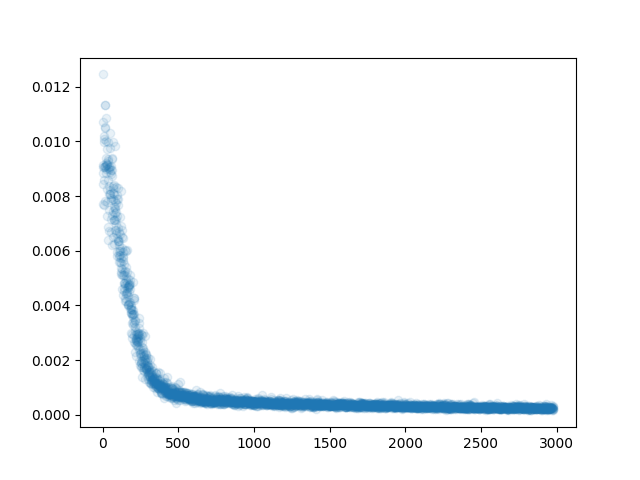

In [15]:
print(f"Minimum epoch_loss found: {jnp.min(jnp.array(epoch_losses))}")
print(f"Last loss found: {epoch_losses[-1]}")

for _ in range(20):
    # Close any prior plots
    plt.close()

plt.scatter(range(len(epoch_losses[20:])), epoch_losses[20:], alpha=0.1)
plt.show()

In [16]:
@jit
def reverse_diffuse(x: Array, t: int, var_schedule: Array, noise: Array) -> Array:
    """
    Compute x(t-1) from x(t) (the state at t), the given variance schedule,
    and the predicted noise.

    x: state after diffusing x_init for t timesteps
    var_schedule: variance schedule of length t (timesteps)
    noise: predicted noise

    Return value:
    x(t-1): (predicted) previous state
    """
    alpha = jnp.cumprod(var_schedule)[t]
    beta = var_schedule[t]
    return (x - beta * noise / jnp.sqrt(1 - alpha)) / jnp.sqrt(1 - beta)


@jit
def generate(
    key, x_init: Array, var_schedule: Array, model: List[List[Array]]
) -> Array:
    x = x_init
    subkeys = random.split(key, num=len(var_schedule) - 1)
    for key, t in zip(subkeys, jnp.flip(jnp.arange(1, len(var_schedule)))):
        # predict noise for denoising
        noise = predict(model, x, t)
        # reverse diffuse one step
        x = reverse_diffuse(x, t, var_schedule, noise)
        # sample Gaussian noise for adding more variance
        z = random.multivariate_normal(key, jnp.zeros(input_dim), jnp.eye(input_dim))
        # add sampled Gaussian noise to x
        x = x + jnp.sqrt(var_schedule[t]) * z

    # x(1) -> x(0) with no additional Gaussian noise
    noise = predict(model, x, 0)
    return reverse_diffuse(x, 0, var_schedule, noise)


In [17]:
batched_reshape = vmap(jit(lambda x: x.reshape(input_shape)))
batched_generate = vmap(generate, in_axes=(0, 0, None, None))

In [18]:
from utils import show_outputs

In [19]:
num_samples = 5

# sample x(t) states to pass into the generator
x_key = random.PRNGKey(19)
x_init_noise = random.multivariate_normal(
    x_key, jnp.zeros(input_dim), jnp.eye(input_dim), shape=(num_samples,)
)
x_init_diffused = batched_forward_diffuse(
    training_data[:num_samples],
    jnp.repeat(1, num_samples),
    var_schedule[:1],
    x_init_noise,
)

In [20]:
generate_key = random.PRNGKey(20)
subkeys = random.split(generate_key, num=num_samples)

x_from_noise = batched_generate(
    subkeys, x_init_noise, var_schedule[:1], trained_model
)
x_from_diffused = batched_generate(
    subkeys, x_init_diffused, var_schedule[:1], trained_model
)

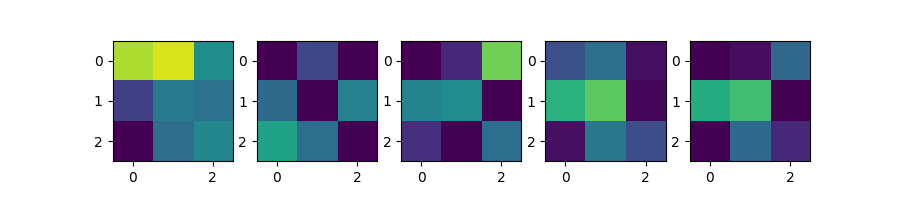

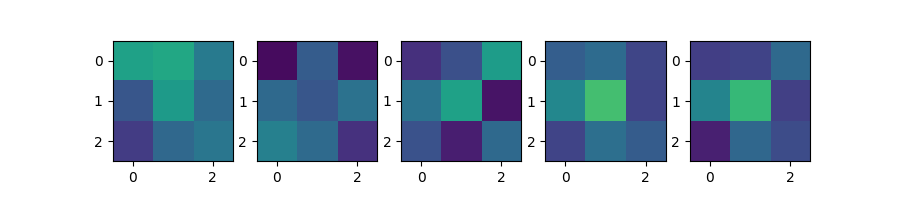

In [21]:
show_outputs(batched_reshape(x_init_noise))
show_outputs(batched_reshape(x_from_noise))

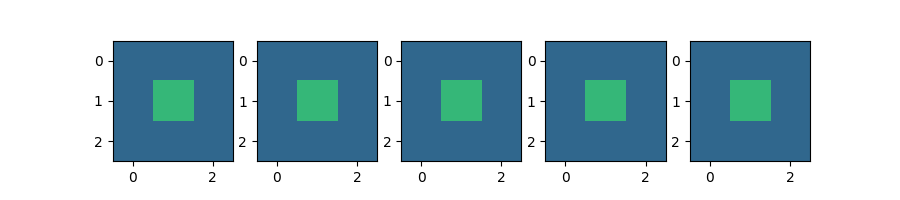

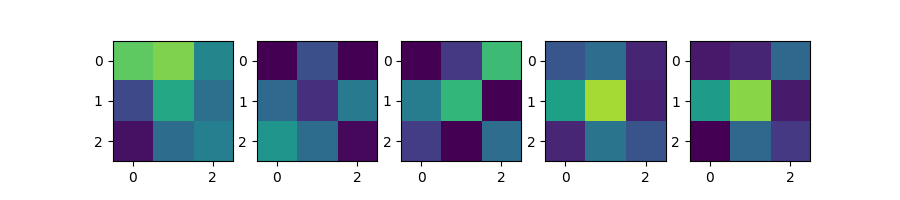

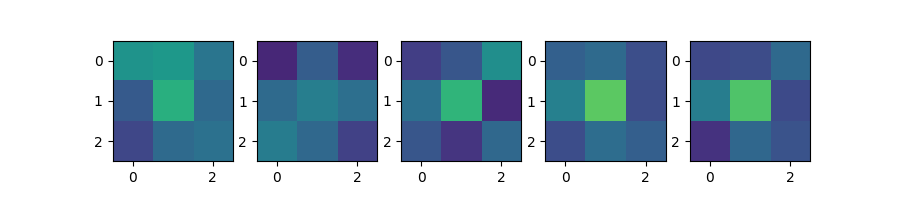

In [22]:
show_outputs(batched_reshape(training_data[:num_samples]))
show_outputs(batched_reshape(x_init_diffused))
show_outputs(batched_reshape(x_from_diffused))

In [23]:
# uncomment and run this if there are too many plots open
# "Figure x" at the top of the current figure means there are x plots open;
# the notebook might complain once x >= 20

# for _ in jnp.arange(30):
#     plt.close()